In [1]:
import os
import shutil
import random
import pandas as pd
import torch
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

In [2]:
# Train_dir = "Museum_Training/Training/"
Test_dir = "Museum_Test/Museum_Validation/"

classification_targets = ['museum-indoor', 'museum-outdoor']

def check_directory(directory):
    if os.path.exists(directory):
        print(f"Directory '{directory}' exists.")
    else:
        print(f"Directory '{directory}' does NOT exist.")

# check_directory(Train_dir)
check_directory(Test_dir)

Directory 'Museum_Test/Museum_Validation/' exists.


In [3]:
def show_dir_content(dir_content,classification_targets):
    
    print(f"Contents of the directory: {dir_content}")
    for clf in classification_targets:
        clf_dir = os.path.join(dir_content, clf)
        if os.path.exists(clf_dir):
            num_images = len(os.listdir(clf_dir))
            print(f"Class '{clf}' contains {num_images} images.")
        else:
            print(f"Class directory '{clf}' does not exist.")

# show_dir_content(Train_dir,classification_targets)
show_dir_content(Test_dir,classification_targets)

Contents of the directory: Museum_Test/Museum_Validation/
Class 'museum-indoor' contains 100 images.
Class 'museum-outdoor' contains 100 images.


In [5]:

image_sizes = []
color_modes = []

for class_name in classification_targets:
    class_dir = os.path.join(Test_dir, class_name)
    if os.path.exists(class_dir):
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            try:
                img = Image.open(img_path)
                image_sizes.append(img.size) 
                color_modes.append(img.mode)  
            except:
                print(f"Error loading {img_path}")

df_sizes = pd.DataFrame(image_sizes, columns=["Width", "Height"])
df_modes = pd.DataFrame(color_modes, columns=["Color Mode"])

print("Image Size Distribution:")
print(df_sizes.describe())

print("\nColor Mode Counts:")
print(df_modes["Color Mode"].value_counts())

Image Size Distribution:
       Width  Height
count  200.0   200.0
mean   256.0   256.0
std      0.0     0.0
min    256.0   256.0
25%    256.0   256.0
50%    256.0   256.0
75%    256.0   256.0
max    256.0   256.0

Color Mode Counts:
RGB    199
L        1
Name: Color Mode, dtype: int64


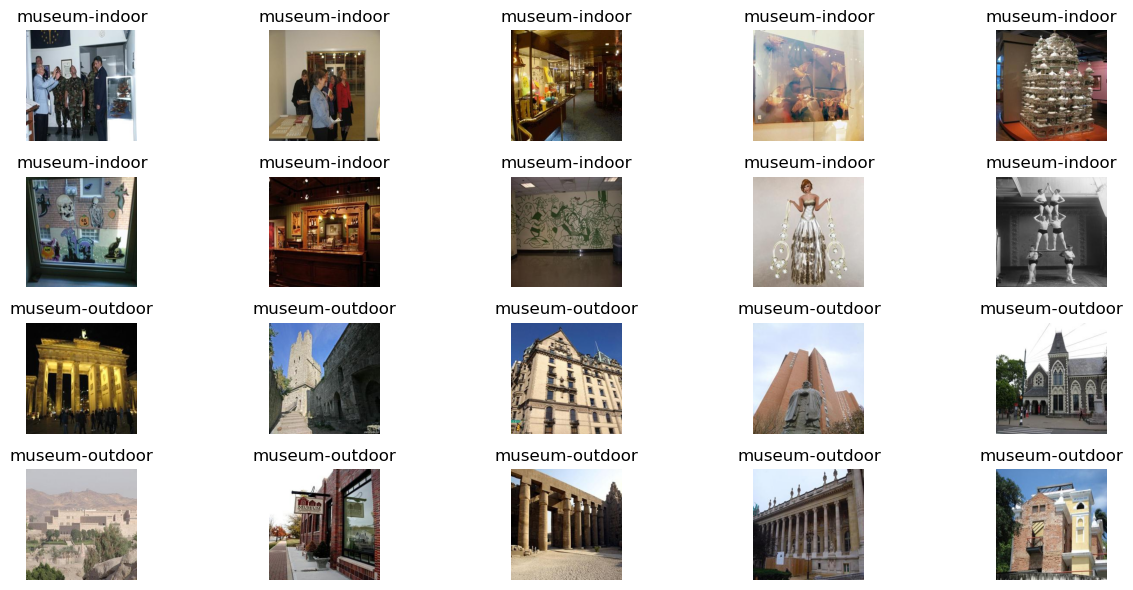

In [8]:

def show_random_images_from_train(Test_dir, classification_targets, num_images=10, images_per_row=5):
    """
    Parameters:
    - Train_dir (str): Path to the training data directory.
    - classification_targets (list): List of class names (subfolders).
    - num_images (int): Number of images to display per class.
    - images_per_row (int): Number of images to display in one row.
    """
    plt.figure(figsize=(13, 6))

    for class_idx, clf in enumerate(classification_targets):
        class_path = os.path.join(Test_dir, clf)

        if not os.path.exists(class_path):
            print(f" Class folder '{clf}' does NOT exist. Skipping.")
            continue

        image_files = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

        if len(image_files) == 0:
            print(f" No images found in class '{clf}'. Skipping.")
            continue

        selected_images = random.sample(image_files, min(num_images, len(image_files)))

        rows = (num_images // images_per_row) + (num_images % images_per_row > 0)

        for i, img_name in enumerate(selected_images):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)

            if img is None:
                print(f" Could not read image: {img_path}. Skipping.")
                continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  

            ax = plt.subplot(len(classification_targets) * rows, images_per_row, class_idx * rows * images_per_row + i + 1)
            plt.imshow(img)
            plt.title(f"{clf}")
            plt.axis("off")

    plt.tight_layout()
    plt.show()

show_random_images_from_train(Test_dir, classification_targets, num_images=10)

In [43]:

image_size = (256, 256) 

def preprocess_new_images(test_dir, classes, method='rgb'):
    """
    Preprocess new test images using the selected method.
    
    Parameters:
    - test_dir (str): Path to the test images.
    - classes (list): List of class labels.
    - method (str): Preprocessing method ('rgb', 'grayscale', 'gaussian_blur').

    Returns:
    - X_test (numpy.ndarray): Processed image data.
    - y_test (numpy.ndarray): Corresponding true labels.
    - file_names (list): List of image file names for reference.
    """
    X_test = []
    y_test = []
    file_names = []

    for label, cls in enumerate(classes):
        class_dir = os.path.join(test_dir, cls)
        if not os.path.exists(class_dir):
            print(f"⚠️ Warning: Directory '{class_dir}' does not exist!")
            continue

        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            try:
                with Image.open(img_path) as img:
                    img = img.convert('RGB')  # Convert to RGB
                    img = img.resize(image_size)  # Resize image
                    img_array = np.array(img)

                    # Convert to grayscale if needed
                    img_gray = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)

                    # Apply preprocessing
                    if method == 'rgb':
                        processed_img = img_array.flatten()
                    elif method == 'grayscale':
                        processed_img = img_gray.flatten()
                    else:
                        raise ValueError("Invalid preprocessing method!")

                    X_test.append(processed_img)
                    y_test.append(label)
                    file_names.append(img_name)

            except Exception as e:
                print(f"Error processing {img_path}: {e}")

    return np.array(X_test), np.array(y_test), file_names

X_test_new, y_test_new, test_files = preprocess_new_images(Test_dir, classification_targets, method='rgb')
X_test_new_grey, y_test_new_grey, test_files_grey = preprocess_new_images(Test_dir, classification_targets, method='grayscale')

print(f"\nProcessed {len(test_files)} new test images!")



Processed 200 new test images!


In [53]:
image_size = (128, 128) 

def preprocess_new_images(test_dir, classes, method='rgb'):
    """
    Preprocess new test images using the selected method.
    
    Parameters:
    - test_dir (str): Path to the test images.
    - classes (list): List of class labels.
    - method (str): Preprocessing method ('rgb', 'grayscale', 'gaussian_blur').

    Returns:
    - X_test (numpy.ndarray): Processed image data.
    - y_test (numpy.ndarray): Corresponding true labels.
    - file_names (list): List of image file names for reference.
    """
    X_test = []
    y_test = []
    file_names = []

    for label, cls in enumerate(classes):
        class_dir = os.path.join(test_dir, cls)
        if not os.path.exists(class_dir):
            print(f"⚠️ Warning: Directory '{class_dir}' does not exist!")
            continue

        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            try:
                with Image.open(img_path) as img:
                    img = img.convert('RGB')  # Convert to RGB
                    img = img.resize(image_size)  # Resize image
                    img_array = np.array(img)

                    # Convert to grayscale if needed
                    img_gray = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)

                    # Apply preprocessing
                    if method == 'rgb':
                        processed_img = img_array.flatten()
                    elif method == 'grayscale':
                        processed_img = img_gray.flatten()
                    else:
                        raise ValueError("Invalid preprocessing method!")

                    X_test.append(processed_img)
                    y_test.append(label)
                    file_names.append(img_name)

            except Exception as e:
                print(f"Error processing {img_path}: {e}")

    return np.array(X_test), np.array(y_test), file_names

X_test_newmin, y_test_newmin, test_filesmin = preprocess_new_images(Test_dir, classification_targets, method='rgb')
X_test_new_greymin, y_test_new_greymin, test_files_greymin = preprocess_new_images(Test_dir, classification_targets, method='grayscale')

print(f"\nProcessed {len(test_files)} new test images!")



Processed 200 new test images!


In [14]:
import pickle
with open("dt_model_gini.pkl", "rb") as dt_model:
    dt_model_gini = pickle.load(dt_model)

In [15]:
y_pred_test = dt_model_gini.predict(X_test_new)
predicted_classes = [classification_targets[i] for i in y_pred_test]
actual_classes = [classification_targets[i] for i in y_pred_test]

In [ ]:
for i in range(min(10, len(test_files))):  # Show first 10 results
    print(f" Image: {test_files[i]} | Actual: {actual_classes[i]} | Predicted: {predicted_classes[i]}")

 Image: Places365_val_00000425.jpg | Actual: museum-indoor | Predicted: museum-indoor
 Image: Places365_val_00000665.jpg | Actual: museum-indoor | Predicted: museum-indoor
 Image: Places365_val_00000826.jpg | Actual: museum-indoor | Predicted: museum-indoor
 Image: Places365_val_00000846.jpg | Actual: museum-indoor | Predicted: museum-indoor
 Image: Places365_val_00000962.jpg | Actual: museum-indoor | Predicted: museum-indoor
 Image: Places365_val_00001187.jpg | Actual: museum-indoor | Predicted: museum-indoor
 Image: Places365_val_00001351.jpg | Actual: museum-indoor | Predicted: museum-indoor
 Image: Places365_val_00001480.jpg | Actual: museum-indoor | Predicted: museum-indoor
 Image: Places365_val_00001538.jpg | Actual: museum-indoor | Predicted: museum-indoor
 Image: Places365_val_00001633.jpg | Actual: museum-indoor | Predicted: museum-indoor
 Image: Places365_val_00001751.jpg | Actual: museum-outdoor | Predicted: museum-outdoor
 Image: Places365_val_00002096.jpg | Actual: museum-

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix

# Compute Metrics
precision, recall, f1, _ = precision_recall_fscore_support(y_test_new, y_pred_test, average='weighted')
accuracy = accuracy_score(y_test_new, y_pred_test)
cm = confusion_matrix(y_test_new, y_pred_test)

# Print Evaluation Results
print("\nEvaluation on New Test Images ---")
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')
print('Confusion Matrix:\n', cm)


Evaluation on New Test Images ---
🔹 Accuracy: 0.8650
🔹 Precision: 0.8668
🔹 Recall: 0.8650
🔹 F1-Score: 0.8648
Confusion Matrix:
 [[90 10]
 [17 83]]


In [18]:
# Identify incorrect predictions
wrong_indices = np.where(y_pred_test != y_test_new)[0]  # Indices where predictions are wrong

# Convert labels to class names
predicted_classes = [classification_targets[i] for i in y_pred_test]
actual_classes = [classification_targets[i] for i in y_test_new]

# Print wrong predictions
print("\n Misclassified Images:")
for i in wrong_indices[:10]:  # Print first 10 misclassified images
    print(f"Image: {test_files[i]} | Actual: {actual_classes[i]} | Predicted: {predicted_classes[i]}")



 Misclassified Images:
Image: Places365_val_00001751.jpg | Actual: museum-indoor | Predicted: museum-outdoor
Image: Places365_val_00002325.jpg | Actual: museum-indoor | Predicted: museum-outdoor
Image: Places365_val_00003470.jpg | Actual: museum-indoor | Predicted: museum-outdoor
Image: Places365_val_00006164.jpg | Actual: museum-indoor | Predicted: museum-outdoor
Image: Places365_val_00006502.jpg | Actual: museum-indoor | Predicted: museum-outdoor
Image: Places365_val_00016252.jpg | Actual: museum-indoor | Predicted: museum-outdoor
Image: Places365_val_00017097.jpg | Actual: museum-indoor | Predicted: museum-outdoor
Image: Places365_val_00032247.jpg | Actual: museum-indoor | Predicted: museum-outdoor
Image: Places365_val_00033745.jpg | Actual: museum-indoor | Predicted: museum-outdoor
Image: Places365_val_00035621.jpg | Actual: museum-indoor | Predicted: museum-outdoor


In [32]:
import pickle
with open("rf_model.pkl", "rb") as rf_model:
    rf_model_rgb = pickle.load(rf_model)

In [33]:
y_pred_test_rf = rf_model_rgb.predict(X_test_new)
predicted_classes_rf = [classification_targets[i] for i in y_pred_test_rf]
actual_classes_rf = [classification_targets[i] for i in y_pred_test_rf]

In [ ]:
for i in range(min(10, len(test_files))):  # Show first 10 results
    print(f" Image: {test_files[i]} | Actual: {actual_classes_rf[i]} | Predicted: {predicted_classes_rf[i]}")

 Image: Places365_val_00000425.jpg | Actual: museum-indoor | Predicted: museum-indoor
 Image: Places365_val_00000665.jpg | Actual: museum-indoor | Predicted: museum-indoor
 Image: Places365_val_00000826.jpg | Actual: museum-indoor | Predicted: museum-indoor
 Image: Places365_val_00000846.jpg | Actual: museum-indoor | Predicted: museum-indoor
 Image: Places365_val_00000962.jpg | Actual: museum-indoor | Predicted: museum-indoor
 Image: Places365_val_00001187.jpg | Actual: museum-indoor | Predicted: museum-indoor
 Image: Places365_val_00001351.jpg | Actual: museum-indoor | Predicted: museum-indoor
 Image: Places365_val_00001480.jpg | Actual: museum-indoor | Predicted: museum-indoor
 Image: Places365_val_00001538.jpg | Actual: museum-indoor | Predicted: museum-indoor
 Image: Places365_val_00001633.jpg | Actual: museum-indoor | Predicted: museum-indoor
 Image: Places365_val_00001751.jpg | Actual: museum-outdoor | Predicted: museum-outdoor
 Image: Places365_val_00002096.jpg | Actual: museum-

In [ ]:
# Compute Metrics
precision, recall, f1, _ = precision_recall_fscore_support(y_test_new, y_pred_test_rf, average='weighted')
accuracy = accuracy_score(y_test_new, y_pred_test_rf)
cm = confusion_matrix(y_test_new, y_pred_test_rf)

# Print Evaluation Results
print("\nEvaluation on New Test Images ---")
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')
print('Confusion Matrix:\n', cm)


Evaluation on New Test Images ---
🔹 Accuracy: 0.8700
🔹 Precision: 0.8713
🔹 Recall: 0.8700
🔹 F1-Score: 0.8699
Confusion Matrix:
 [[90 10]
 [16 84]]


In [37]:
# Identify incorrect predictions
wrong_indices = np.where(y_pred_test_rf != y_test_new)[0]  # Indices where predictions are wrong

# Convert labels to class names
predicted_classes_rf = [classification_targets[i] for i in y_pred_test_rf]
actual_classes_rf = [classification_targets[i] for i in y_test_new]

# Print wrong predictions
print("\n Misclassified Images:")
for i in wrong_indices[:10]:  # Print first 10 misclassified images
    print(f"Image: {test_files[i]} | Actual: {actual_classes_rf[i]} | Predicted: {predicted_classes_rf[i]}")


 Misclassified Images:
Image: Places365_val_00001751.jpg | Actual: museum-indoor | Predicted: museum-outdoor
Image: Places365_val_00002325.jpg | Actual: museum-indoor | Predicted: museum-outdoor
Image: Places365_val_00003470.jpg | Actual: museum-indoor | Predicted: museum-outdoor
Image: Places365_val_00006164.jpg | Actual: museum-indoor | Predicted: museum-outdoor
Image: Places365_val_00017097.jpg | Actual: museum-indoor | Predicted: museum-outdoor
Image: Places365_val_00022384.jpg | Actual: museum-indoor | Predicted: museum-outdoor
Image: Places365_val_00025073.jpg | Actual: museum-indoor | Predicted: museum-outdoor
Image: Places365_val_00027717.jpg | Actual: museum-indoor | Predicted: museum-outdoor
Image: Places365_val_00028057.jpg | Actual: museum-indoor | Predicted: museum-outdoor
Image: Places365_val_00032247.jpg | Actual: museum-indoor | Predicted: museum-outdoor


In [40]:
import pickle
with open("dt_model_entropy_grey.pkl", "rb") as dt_model_grey:
    dt_model_grey_entropy = pickle.load(dt_model_grey)

In [44]:
y_pred_test_dt_grey = dt_model_grey_entropy.predict(X_test_new_grey)
predicted_classes_dt_grey = [classification_targets[i] for i in y_pred_test_dt_grey]
actual_classes_dt_grey = [classification_targets[i] for i in y_pred_test_dt_grey]

In [45]:
for i in range(min(10, len(test_files_grey))):  # Show first 10 results
    print(f" Image: {test_files_grey[i]} | Actual: {actual_classes_dt_grey[i]} | Predicted: {predicted_classes_dt_grey[i]}")

 Image: Places365_val_00000425.jpg | Actual: museum-indoor | Predicted: museum-indoor
 Image: Places365_val_00000665.jpg | Actual: museum-indoor | Predicted: museum-indoor
 Image: Places365_val_00000826.jpg | Actual: museum-indoor | Predicted: museum-indoor
 Image: Places365_val_00000846.jpg | Actual: museum-indoor | Predicted: museum-indoor
 Image: Places365_val_00000962.jpg | Actual: museum-indoor | Predicted: museum-indoor
 Image: Places365_val_00001187.jpg | Actual: museum-indoor | Predicted: museum-indoor
 Image: Places365_val_00001351.jpg | Actual: museum-indoor | Predicted: museum-indoor
 Image: Places365_val_00001480.jpg | Actual: museum-indoor | Predicted: museum-indoor
 Image: Places365_val_00001538.jpg | Actual: museum-indoor | Predicted: museum-indoor
 Image: Places365_val_00001633.jpg | Actual: museum-indoor | Predicted: museum-indoor


In [46]:
# Compute Metrics
precision, recall, f1, _ = precision_recall_fscore_support(y_test_new_grey, y_pred_test_dt_grey, average='weighted')
accuracy = accuracy_score(y_test_new_grey, y_pred_test_dt_grey)
cm = confusion_matrix(y_test_new_grey, y_pred_test_dt_grey)

# Print Evaluation Results
print("\nEvaluation on New Test Images ---")
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')
print('Confusion Matrix:\n', cm)


Evaluation on New Test Images ---
Accuracy: 0.6450
Precision: 0.6564
Recall: 0.6450
F1-Score: 0.6384
Confusion Matrix:
 [[78 22]
 [49 51]]


In [47]:
# Identify incorrect predictions
wrong_indices = np.where(y_pred_test_dt_grey != y_test_new_grey)[0]  # Indices where predictions are wrong

# Convert labels to class names
predicted_classes_dt_grey = [classification_targets[i] for i in y_pred_test_dt_grey]
actual_classes_dt_grey = [classification_targets[i] for i in y_test_new_grey]

# Print wrong predictions
print("\n Misclassified Images:")
for i in wrong_indices[:10]:  # Print first 10 misclassified images
    print(f"Image: {test_files_grey[i]} | Actual: {actual_classes_dt_grey[i]} | Predicted: {predicted_classes_dt_grey[i]}")


 Misclassified Images:
Image: Places365_val_00001751.jpg | Actual: museum-indoor | Predicted: museum-outdoor
Image: Places365_val_00002325.jpg | Actual: museum-indoor | Predicted: museum-outdoor
Image: Places365_val_00003470.jpg | Actual: museum-indoor | Predicted: museum-outdoor
Image: Places365_val_00003535.jpg | Actual: museum-indoor | Predicted: museum-outdoor
Image: Places365_val_00005673.jpg | Actual: museum-indoor | Predicted: museum-outdoor
Image: Places365_val_00006164.jpg | Actual: museum-indoor | Predicted: museum-outdoor
Image: Places365_val_00009173.jpg | Actual: museum-indoor | Predicted: museum-outdoor
Image: Places365_val_00012095.jpg | Actual: museum-indoor | Predicted: museum-outdoor
Image: Places365_val_00012587.jpg | Actual: museum-indoor | Predicted: museum-outdoor
Image: Places365_val_00017097.jpg | Actual: museum-indoor | Predicted: museum-outdoor


In [48]:
import pickle
with open("rf_model_grey.pkl", "rb") as rf_model_grey:
    rf_mdl_grey = pickle.load(rf_model_grey)

In [49]:
y_pred_test_rf_grey = rf_mdl_grey.predict(X_test_new_grey)
predicted_classes_rf_grey = [classification_targets[i] for i in y_pred_test_rf_grey]
actual_classes_rf_grey = [classification_targets[i] for i in y_pred_test_rf_grey]

In [50]:
for i in range(min(10, len(test_files_grey))):  # Show first 10 results
    print(f" Image: {test_files_grey[i]} | Actual: {actual_classes_rf_grey[i]} | Predicted: {predicted_classes_rf_grey[i]}")

 Image: Places365_val_00000425.jpg | Actual: museum-outdoor | Predicted: museum-outdoor
 Image: Places365_val_00000665.jpg | Actual: museum-outdoor | Predicted: museum-outdoor
 Image: Places365_val_00000826.jpg | Actual: museum-indoor | Predicted: museum-indoor
 Image: Places365_val_00000846.jpg | Actual: museum-indoor | Predicted: museum-indoor
 Image: Places365_val_00000962.jpg | Actual: museum-indoor | Predicted: museum-indoor
 Image: Places365_val_00001187.jpg | Actual: museum-indoor | Predicted: museum-indoor
 Image: Places365_val_00001351.jpg | Actual: museum-indoor | Predicted: museum-indoor
 Image: Places365_val_00001480.jpg | Actual: museum-indoor | Predicted: museum-indoor
 Image: Places365_val_00001538.jpg | Actual: museum-indoor | Predicted: museum-indoor
 Image: Places365_val_00001633.jpg | Actual: museum-indoor | Predicted: museum-indoor


In [51]:
# Compute Metrics
precision, recall, f1, _ = precision_recall_fscore_support(y_test_new_grey, y_pred_test_rf_grey, average='weighted')
accuracy = accuracy_score(y_test_new_grey, y_pred_test_rf_grey)
cm = confusion_matrix(y_test_new_grey, y_pred_test_rf_grey)

# Print Evaluation Results
print("\nEvaluation on New Test Images ---")
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')
print('Confusion Matrix:\n', cm)


Evaluation on New Test Images ---
Accuracy: 0.7300
Precision: 0.7308
Recall: 0.7300
F1-Score: 0.7298
Confusion Matrix:
 [[76 24]
 [30 70]]


In [52]:
# Identify incorrect predictions
wrong_indices = np.where(y_pred_test_rf_grey != y_test_new_grey)[0]  # Indices where predictions are wrong

# Convert labels to class names
predicted_classes_rf_grey = [classification_targets[i] for i in y_pred_test_rf_grey]
actual_classes_rf_grey = [classification_targets[i] for i in y_test_new_grey]

# Print wrong predictions
print("\n Misclassified Images:")
for i in wrong_indices[:10]:  # Print first 10 misclassified images
    print(f"Image: {test_files_grey[i]} | Actual: {actual_classes_rf_grey[i]} | Predicted: {predicted_classes_rf_grey[i]}")


 Misclassified Images:
Image: Places365_val_00000425.jpg | Actual: museum-indoor | Predicted: museum-outdoor
Image: Places365_val_00000665.jpg | Actual: museum-indoor | Predicted: museum-outdoor
Image: Places365_val_00001751.jpg | Actual: museum-indoor | Predicted: museum-outdoor
Image: Places365_val_00002325.jpg | Actual: museum-indoor | Predicted: museum-outdoor
Image: Places365_val_00003470.jpg | Actual: museum-indoor | Predicted: museum-outdoor
Image: Places365_val_00006164.jpg | Actual: museum-indoor | Predicted: museum-outdoor
Image: Places365_val_00006502.jpg | Actual: museum-indoor | Predicted: museum-outdoor
Image: Places365_val_00009173.jpg | Actual: museum-indoor | Predicted: museum-outdoor
Image: Places365_val_00012774.jpg | Actual: museum-indoor | Predicted: museum-outdoor
Image: Places365_val_00017097.jpg | Actual: museum-indoor | Predicted: museum-outdoor


In [54]:
import pickle
with open("xgb_model.pkl", "rb") as xgb_model:
    xgb_model_rgb = pickle.load(xgb_model)

In [55]:
y_pred_test_xgb = xgb_model_rgb.predict(X_test_newmin)
predicted_classes_xgb = [classification_targets[i] for i in y_pred_test_xgb]
actual_classes_xgb = [classification_targets[i] for i in y_pred_test_xgb]

In [56]:
for i in range(min(10, len(test_filesmin))):  # Show first 10 results
    print(f" Image: {test_filesmin[i]} | Actual: {actual_classes_xgb[i]} | Predicted: {predicted_classes_xgb[i]}")

 Image: Places365_val_00000425.jpg | Actual: museum-indoor | Predicted: museum-indoor
 Image: Places365_val_00000665.jpg | Actual: museum-indoor | Predicted: museum-indoor
 Image: Places365_val_00000826.jpg | Actual: museum-indoor | Predicted: museum-indoor
 Image: Places365_val_00000846.jpg | Actual: museum-indoor | Predicted: museum-indoor
 Image: Places365_val_00000962.jpg | Actual: museum-indoor | Predicted: museum-indoor
 Image: Places365_val_00001187.jpg | Actual: museum-indoor | Predicted: museum-indoor
 Image: Places365_val_00001351.jpg | Actual: museum-indoor | Predicted: museum-indoor
 Image: Places365_val_00001480.jpg | Actual: museum-indoor | Predicted: museum-indoor
 Image: Places365_val_00001538.jpg | Actual: museum-indoor | Predicted: museum-indoor
 Image: Places365_val_00001633.jpg | Actual: museum-indoor | Predicted: museum-indoor


In [57]:
# Compute Metrics
precision, recall, f1, _ = precision_recall_fscore_support(y_test_newmin, y_pred_test_xgb, average='weighted')
accuracy = accuracy_score(y_test_newmin, y_pred_test_xgb)
cm = confusion_matrix(y_test_newmin, y_pred_test_xgb)

# Print Evaluation Results
print("\nEvaluation on New Test Images ---")
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')
print('Confusion Matrix:\n', cm)


Evaluation on New Test Images ---
Accuracy: 0.8900
Precision: 0.8914
Recall: 0.8900
F1-Score: 0.8899
Confusion Matrix:
 [[92  8]
 [14 86]]


In [63]:
# Identify incorrect predictions
wrong_indices = np.where(y_pred_test_xgb != y_test_newmin)[0]  # Indices where predictions are wrong

# Convert labels to class names
predicted_classes_xgb_ = [classification_targets[i] for i in y_pred_test_xgb]
actual_classes_xgb = [classification_targets[i] for i in y_test_newmin]

# Print wrong predictions
print("\n Misclassified Images:")
for i in wrong_indices[:10]:  # Print first 10 misclassified images
    print(f"Image: {test_filesmin[i]} | Actual: {actual_classes_xgb[i]} | Predicted: {predicted_classes_xgb[i]}")


 Misclassified Images:
Image: Places365_val_00001751.jpg | Actual: museum-indoor | Predicted: museum-outdoor
Image: Places365_val_00002325.jpg | Actual: museum-indoor | Predicted: museum-outdoor
Image: Places365_val_00003470.jpg | Actual: museum-indoor | Predicted: museum-outdoor
Image: Places365_val_00006164.jpg | Actual: museum-indoor | Predicted: museum-outdoor
Image: Places365_val_00017097.jpg | Actual: museum-indoor | Predicted: museum-outdoor
Image: Places365_val_00022384.jpg | Actual: museum-indoor | Predicted: museum-outdoor
Image: Places365_val_00025073.jpg | Actual: museum-indoor | Predicted: museum-outdoor
Image: Places365_val_00027717.jpg | Actual: museum-indoor | Predicted: museum-outdoor
Image: Places365_val_00002832.jpg | Actual: museum-outdoor | Predicted: museum-indoor
Image: Places365_val_00004666.jpg | Actual: museum-outdoor | Predicted: museum-indoor


In [64]:
import pickle
with open("xgb_model_grey.pkl", "rb") as xgb_model_grey:
    xgb_model_gry = pickle.load(xgb_model_grey)

In [66]:
y_pred_test_xgb_grey = xgb_model_gry.predict(X_test_new_greymin)
predicted_classes_grey = [classification_targets[i] for i in y_pred_test_xgb_grey]
actual_classes_grey = [classification_targets[i] for i in y_pred_test_xgb_grey]

for i in range(min(10, len(test_files_greymin))):  # Show first 10 results
    print(f" Image: {test_files_greymin[i]} | Actual: {actual_classes_grey[i]} | Predicted: {predicted_classes_grey[i]}")

 Image: Places365_val_00000425.jpg | Actual: museum-outdoor | Predicted: museum-outdoor
 Image: Places365_val_00000665.jpg | Actual: museum-outdoor | Predicted: museum-outdoor
 Image: Places365_val_00000826.jpg | Actual: museum-indoor | Predicted: museum-indoor
 Image: Places365_val_00000846.jpg | Actual: museum-indoor | Predicted: museum-indoor
 Image: Places365_val_00000962.jpg | Actual: museum-indoor | Predicted: museum-indoor
 Image: Places365_val_00001187.jpg | Actual: museum-indoor | Predicted: museum-indoor
 Image: Places365_val_00001351.jpg | Actual: museum-indoor | Predicted: museum-indoor
 Image: Places365_val_00001480.jpg | Actual: museum-indoor | Predicted: museum-indoor
 Image: Places365_val_00001538.jpg | Actual: museum-indoor | Predicted: museum-indoor
 Image: Places365_val_00001633.jpg | Actual: museum-indoor | Predicted: museum-indoor


In [68]:
# Compute Metrics
precision, recall, f1, _ = precision_recall_fscore_support(y_test_new_greymin, y_pred_test_xgb_grey, average='weighted')
accuracy = accuracy_score(y_test_new_greymin, y_pred_test_xgb_grey)
cm = confusion_matrix(y_test_new_greymin, y_pred_test_xgb_grey)

# Print Evaluation Results
print("\nEvaluation on New Test Images ---")
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')
print('Confusion Matrix:\n', cm)


Evaluation on New Test Images ---
Accuracy: 0.7700
Precision: 0.7717
Recall: 0.7700
F1-Score: 0.7696
Confusion Matrix:
 [[81 19]
 [27 73]]


In [71]:
# Identify incorrect predictions
wrong_indices = np.where(y_pred_test_xgb_grey != y_test_new_greymin)[0]  # Indices where predictions are wrong

# Convert labels to class names
predicted_classes_grey = [classification_targets[i] for i in y_pred_test_xgb_grey]
actual_classes_grey = [classification_targets[i] for i in y_test_new_greymin]

# Print wrong predictions
print("\n Misclassified Images:")
for i in wrong_indices[:10]:  # Print first 10 misclassified images
    print(f"Image: {test_filesmin[i]} | Actual: {actual_classes_grey[i]} | Predicted: {predicted_classes_grey[i]}")


 Misclassified Images:
Image: Places365_val_00000425.jpg | Actual: museum-indoor | Predicted: museum-outdoor
Image: Places365_val_00000665.jpg | Actual: museum-indoor | Predicted: museum-outdoor
Image: Places365_val_00001751.jpg | Actual: museum-indoor | Predicted: museum-outdoor
Image: Places365_val_00002325.jpg | Actual: museum-indoor | Predicted: museum-outdoor
Image: Places365_val_00003470.jpg | Actual: museum-indoor | Predicted: museum-outdoor
Image: Places365_val_00003535.jpg | Actual: museum-indoor | Predicted: museum-outdoor
Image: Places365_val_00005673.jpg | Actual: museum-indoor | Predicted: museum-outdoor
Image: Places365_val_00006164.jpg | Actual: museum-indoor | Predicted: museum-outdoor
Image: Places365_val_00006502.jpg | Actual: museum-indoor | Predicted: museum-outdoor
Image: Places365_val_00009173.jpg | Actual: museum-indoor | Predicted: museum-outdoor
